In [1]:
from torch.utils.data import Dataset
from skimage.color import rgb2lab, lab2rgb, rgb2gray
import numpy as np
import random
import cv2
import os

random.seed(42069)

In [223]:
# Utils
def pepper_noise(img, threshold=0.1, amount = 0.5):
    h, w, ch = img.shape
    img_lab = rgb2lab(img)
    img_l = img_lab[..., 0].reshape(h, w) / 100 # Normalize the luminosity between 0 and 1
    mask = np.random.rand(h, w)
    val = (np.exp(img_l) / np.exp(img_l).max() + threshold)
    out = img.copy()
    print("pepper : " + str(amount))
    amount = amount ** 2 
    if amount < 0.5:
        amount = amount * 2
        val = (amount * val) + (1 - amount)
    else:
        amount = (2 * amount) - 1
        val *= (1 - amount)
    out[mask > val, :] = 0
    return out

def gaussian_noise(img, amount=0.2, calibration=0.05):
    h, w, ch = img.shape
    noise = np.random.normal(0, amount, (h, w, ch)) - calibration
    
    out = img.copy() / 255
    
    out = out + noise
    out = np.clip(out, 0, 1)
    return np.float32(out)

In [224]:
# A class defining the dataset
class ImageDataset(Dataset):
    def __init__(self, images_folder: list, g_min = 0.02, g_max = 0.08, p_min = 0.3, p_max = 0.75):
        super().__init__()
        files = [file for file in os.listdir(images_folder)]
        self.image_paths = [images_folder + "/" + file for file in files if file.endswith(('.png', '.jpg'))]
        self.g_min = g_min
        self.g_max = g_max
        self.p_min = p_min
        self.p_max = p_max
        
    # Returns the number of samples, it is used for iteration porpuses
    def __len__(self):
        return len(self.image_paths)
    
    # Returns a random sample for training(generally)
    def __getitem__(self, idx):
        # Load RANDOM clean image into memory...
        image_path = self.image_paths[idx]
        clean_image = cv2.imread(image_path)
        # Generate the noisy image...
        noisy_image = clean_image
        noisy_image = pepper_noise(
            noisy_image,
            threshold = 0.01,
            amount = random.uniform(self.g_min, self.g_max)
        )
        noisy_image = gaussian_noise(
            noisy_image,
            amount = random.uniform(self.g_min, self.g_max)
        )
        
        
        return {
            'x': cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB),
            'y': cv2.cvtColor(clean_image, cv2.COLOR_BGR2RGB)
        }

# Test

pepper : 0.06728664280870032
pepper : 0.7


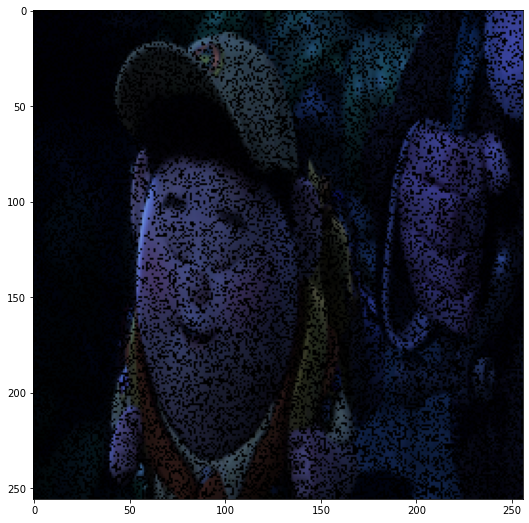

In [225]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
plt.figure(figsize=(16,9))

mock_dataset = ImageDataset("data/train")
img = pepper_noise(mock_dataset[0]["y"], threshold= 0.01, amount= 0.7)
plt.imshow(img)
# for idx in random.shuffle(range(0, len(mock_dataset)))
# plt.imshow(mock_dataset[idx]["x"][0])
# mock_loader = DataLoader(mock_dataset, batch_size = 1,shuffle = True)
# fg = plt.figure(figsize=(16, 9))
# for sample in mock_loader:
    # pass
    #plt.imshow(sample["x"][0])


img/sponza_16spp_oidn.png
pepper : 0.065214623290739


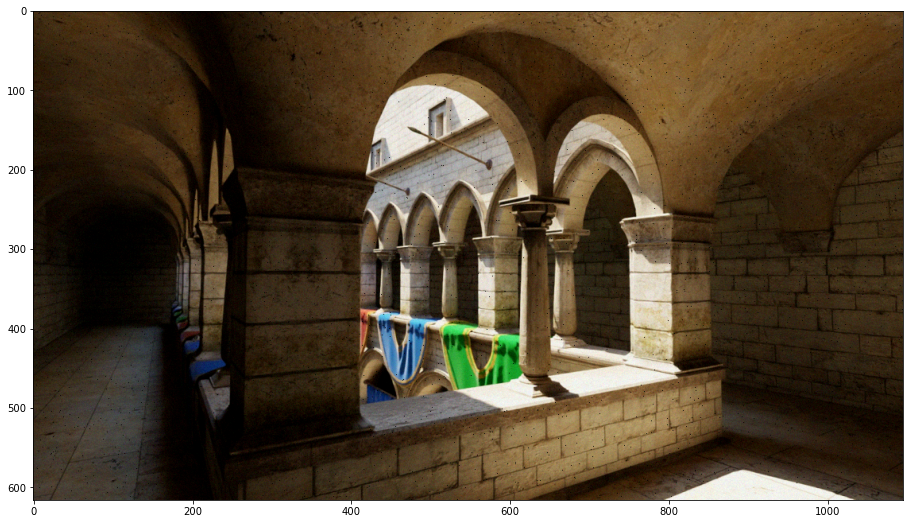

In [226]:
import os
from PIL import Image
plt.figure(figsize=(16,9))

from models.generator import Generator

img_dataset = ImageDataset("img")

print(img_dataset.image_paths[0])
generator = Generator(0.1, 0.1, 0.1, 0.1, 1)
# img = Image.fromarray(cv2.cvtColor(img_dataset[0]["x"], cv2.COLOR_BGR2RGB))
# result = generator.forward(img_dataset[0]["x"])
# plt.imshow(result)
plt.imshow(img_dataset[0]["x"])